<a href="https://colab.research.google.com/github/Terizea/EfficientNet-CIFAR10/blob/main/EfficientNet_90_37_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting drive/app/cifar10/cifar-10-python.tar.gz to drive/app/cifar10/
Files already downloaded and verified

Epoch: 0
train: [39/391] Loss: 2.265 | Acc: 21.406% (1096/5120)
train: [79/391] Loss: 2.054 | Acc: 26.475% (2711/10240)
train: [119/391] Loss: 1.948 | Acc: 29.688% (4560/15360)
train: [159/391] Loss: 1.874 | Acc: 32.178% (6590/20480)
train: [199/391] Loss: 1.821 | Acc: 34.070% (8722/25600)
train: [239/391] Loss: 1.780 | Acc: 35.511% (10909/30720)
train: [279/391] Loss: 1.745 | Acc: 36.749% (13171/35840)
train: [319/391] Loss: 1.712 | Acc: 38.098% (15605/40960)
train: [359/391] Loss: 1.681 | Acc: 39.191% (18059/46080)
val: [39/79] Loss: 1.302 | Acc: 53.984% (2764/5120)
Saving..
.pth saved
Learing rate:  0.0009757729755661011

Epoch: 1
train: [39/391] Loss: 1.385 | Acc: 49.414% (2530/5120)
train: [79/391] Loss: 1.364 | Acc: 50.508% (5172/10240)
train: [119/391] Loss: 1.358 | Acc: 50.944% (7825/15360)
train: [159/391] Loss: 1.338 | Acc: 51.660% (10580/20480)
train: [199/391] Lo

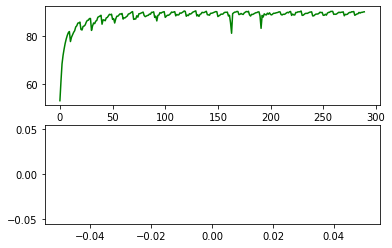

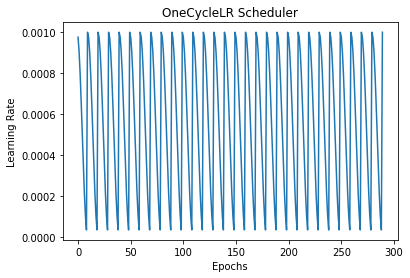

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms         
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import os
from torchsummary import summary 
import matplotlib.pyplot as plt

batch_size = 128
root_dir = 'drive/app/cifar10/'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),   
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467), # RGB Normalize MEAN
                         std=(0.2471, 0.2436, 0.2616))  # RGB Normalize Standard Deviation
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467), # RGB Normalize MEAN
                         std=(0.2471, 0.2436, 0.2616))  # RGB Normalize Standard Deviation
])


trainset = torchvision.datasets.CIFAR10(root=root_dir,
                                        train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=root_dir,
                                       train=False, 
                                       download=True, 
                                       transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False, 
                                         num_workers=2)

class Swish(nn.Module):
    def __init__(self, inplace: bool=False):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.inplace=inplace

    def forward(self, x):
        return x * self.sigmoid(x)

class Block(nn.Module):
    '''expand + depthwise + pointwise + squeeze-excitation'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d( in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d( planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d( planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)
        self.swish=Swish(inplace=True)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1,
                          stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

        # SE layers
        self.fc1 = nn.Conv2d(out_planes, out_planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(out_planes//16, out_planes, kernel_size=1)

    def forward(self, x):
        out = self.swish(self.bn1(self.conv1(x)))
        out = self.swish(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        shortcut = self.shortcut(x) if self.stride == 1 else out
        # Squeeze-Excitation
        w = F.avg_pool2d(out, out.size(2))
        w = self.swish(self.fc1(w))
        w = self.fc2(w).sigmoid()
        out = out * w + shortcut
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(cfg[-1][1], num_classes)
        self.swish = Swish(inplace=True)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def EfficientNetB0():
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 2),
           (6,  24, 2, 1),
           (6,  40, 2, 2),
           (6,  80, 3, 2),
           (6, 112, 3, 1),
           (6, 192, 4, 2),
           (6, 320, 1, 2)]
    return EfficientNet(cfg)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = EfficientNetB0()
net = net.to(device)
# Load checkpoint.
#assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
best_acc = 0.0
start_epoch = 0
if os.path.exists('./checkpoint/EfficientNet.pth'):
    checkpoint = torch.load('./checkpoint/EfficientNet.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=0.00001)
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,   steps_per_epoch=len(trainloader), epochs=290)

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 40 == 39:
            print('train: [%d/%d] Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (batch_idx, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        if batch_idx == 390:
            train_loss_values.append(100. * correct / total)    

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 40 == 39:
                print('val: [%d/%d] Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (batch_idx, len(testloader), test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        test_loss_values.append(100. * correct / total)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/EfficientNet.pth')
        print(".pth saved")
        best_acc = acc

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

train_loss_values=[]
test_loss_values=[]
lrs  = []

#for epoch in range(start_epoch, start_epoch+1):
for epoch in range(start_epoch, 290):
    train(epoch)
    test(epoch)
    scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])  
    print("Learing rate: ",get_lr(optimizer))

print("best accurary %f%%"%best_acc)

summary(net.cuda(), (3,32,32),batch_size = 128)

plt.plot(test_loss_values, 'g-', label='Test loss')
plt.show()
plt.plot(train_loss_values, 'r-', label='Train loss')
plt.show()

plt.plot(lrs)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("OneCycleLR Scheduler")
plt.show()

Confusion matrix, without normalization
[[923   3  19  11   2   1   2   4  25  10]
 [ 11 955   1   1   0   0   0   1   5  26]
 [ 21   0 859  27  29  20  26   9   6   3]
 [  8   2  35 772  20 112  31  12   3   5]
 [  7   2  19  18 899  20  16  18   1   0]
 [  3   2  16  71  20 868   4  14   0   2]
 [  4   0  21  24   5   7 937   0   1   1]
 [ 11   0  12  13  18  21   1 920   2   2]
 [ 28   6   5  10   2   1   0   1 937  10]
 [ 11  36   4   4   0   0   2   3  13 927]]


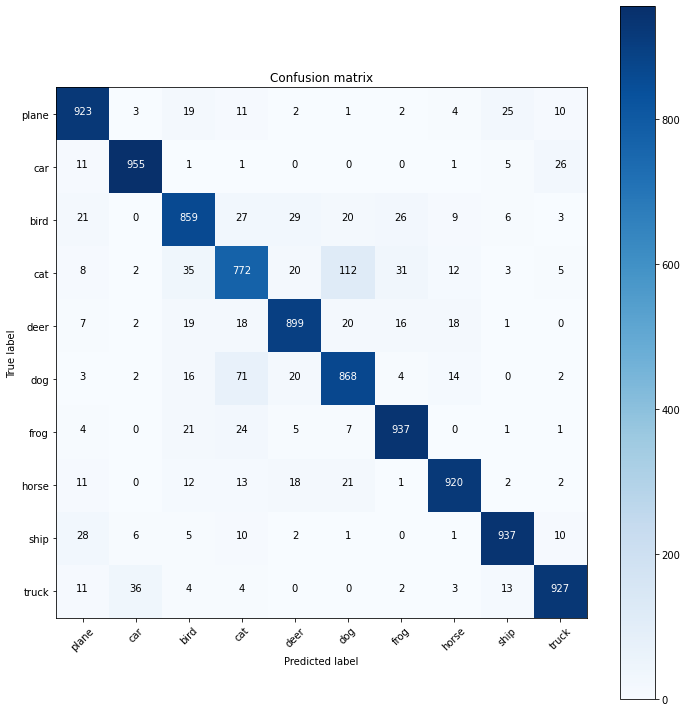

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

@torch.no_grad()

#def get_all_preds(modell, loader):
#  all_preds = torch.tensor([])
#  for batch in loader:
#    images, labels = batch
#    images, labels = images.to(device), labels.to(device)

#    preds = modell(images)
#    all_preds = torch.cat((all_preds.to(device), preds.to(device)) ,dim=0)

#  return all_preds


def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    preds = model(images)
    all_preds = torch.cat((all_preds.to(device), preds.to(device)) ,dim=0)

  return all_preds

test_preds = get_all_preds(net, testloader)   

from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(testset.targets, test_preds.argmax(dim=1).cpu())
cm = confusion_matrix(testset.targets, test_preds.argmax(dim=1).cpu())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)